# Wine Quality Prediction Model

## Introduction

The following notebook contains my original code to explore the UCI ML Wine Quality dataset (https://doi.org/10.24432/C56S3T) and create a linear regression model from it.

The goal of the project is to create and apply a machine learning model to predict the quality of a red wine from its chemical properties such as fixed acidity, density, pH, and more. We will also explore the data using various descriptive methods like scatterplots, correlation matrices, and box plots. A winery could apply this model in quality assurance as they test newly created wines, or use it to make pricing decisions based on wine quality.

## Import necessary libraries, modules, and datasets

In the following code block, we import the libraries and modules necessary for the rest of the program. Among these are the UCI ML Repository to import the dataset, as well as pandas, seaborn, scikit learn, and numpy.

After fetching the wine dataset from the UCI repo, we convert it to a dataframe and remove the white wines so we're only left with the reds. We define the features (X) and the target (y) for the regression model we will build later in the program.


In [1]:
# import libraries and modules
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# fetch dataset and convert to pandas dataframe
wine_quality = fetch_ucirepo(id=186)
df = pd.concat([wine_quality.data.features, wine_quality.data.targets], axis=1)

# add 'color' column from original dataset which is not included in features
df['color'] = wine_quality.data.original['color']

df = df[df['color'] == 'red']  # redefine df to only include red wines

# drop color as it is no longer needed
df = df.drop('color', axis=1)

# define X and y for modeling later
X = df.drop('quality', axis=1)
y = df['quality']

## Initial data exploration

After importing our data, we need to explore it. The library *ucimlrepo* has a built-in function called *variables* to check some of the metadata for each column. Some key takeaways are that most datatypes are continuous numerical values, minus quality (integer) and color (categorical). We also learn that units were not included, but luckily we can infer them with some research. Lastly, we see that there are no missing values in any columns.

In [2]:
print(wine_quality.variables)

                    name     role         type demographic  \
0          fixed_acidity  Feature   Continuous        None   
1       volatile_acidity  Feature   Continuous        None   
2            citric_acid  Feature   Continuous        None   
3         residual_sugar  Feature   Continuous        None   
4              chlorides  Feature   Continuous        None   
5    free_sulfur_dioxide  Feature   Continuous        None   
6   total_sulfur_dioxide  Feature   Continuous        None   
7                density  Feature   Continuous        None   
8                     pH  Feature   Continuous        None   
9              sulphates  Feature   Continuous        None   
10               alcohol  Feature   Continuous        None   
11               quality   Target      Integer        None   
12                 color    Other  Categorical        None   

               description units missing_values  
0                     None  None             no  
1                     None  Non

We can then print the first five rows of the dataframe using *pandas.head()* to get a peek at some granular data.

In [3]:
print(df.head())

   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

After seeing some of the values in our dataframe, I wanted to understand the range of each field. I used *pandas.describe()* to pull the min, max, and mean of each column.

In [4]:
# print ranges and average for each column
print(df.describe().loc[['min', 'max', 'mean']])

      fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
min        4.600000          0.120000     0.000000        0.900000   0.012000   
max       15.900000          1.580000     1.000000       15.500000   0.611000   
mean       8.319637          0.527821     0.270976        2.538806   0.087467   

      free_sulfur_dioxide  total_sulfur_dioxide   density        pH  \
min              1.000000              6.000000  0.990070  2.740000   
max             72.000000            289.000000  1.003690  4.010000   
mean            15.874922             46.467792  0.996747  3.311113   

      sulphates    alcohol   quality  
min    0.330000   8.400000  3.000000  
max    2.000000  14.900000  8.000000  
mean   0.658149  10.422983  5.636023  


## Further Data Exploration with Descriptive Visuals

In order to explore the data further, some visual representations would be helpful. I decided to first examine our target for the model, wine quality, measured on a scale from 0 to 10. I used seaborn to create a histogram to show the frequency of each value in this column.

### Histogram of quality score

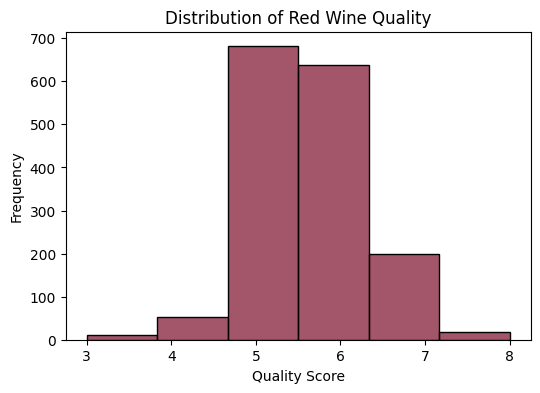

In [5]:
# histogram
plt.figure(figsize=(6, 4))
sns.histplot(df['quality'], bins=6, color='#851E38')
plt.title('Distribution of Red Wine Quality')
plt.xlabel('Quality Score')
plt.ylabel('Frequency')
plt.show()

The above histogram shows us we have a fairly normal bell curve for the wine quality variable, but the lowest and highest values are underrepresented. We must keep this in mind as we train and apply our model in the future.

### Correlation Heatmap of all features

Next, I wanted to look for any strong correlations between features that could be redundant in training our model. I decided to create a correlation matrix to clearly see relationships between variables using color. The darker the shade, the stronger the correlation.

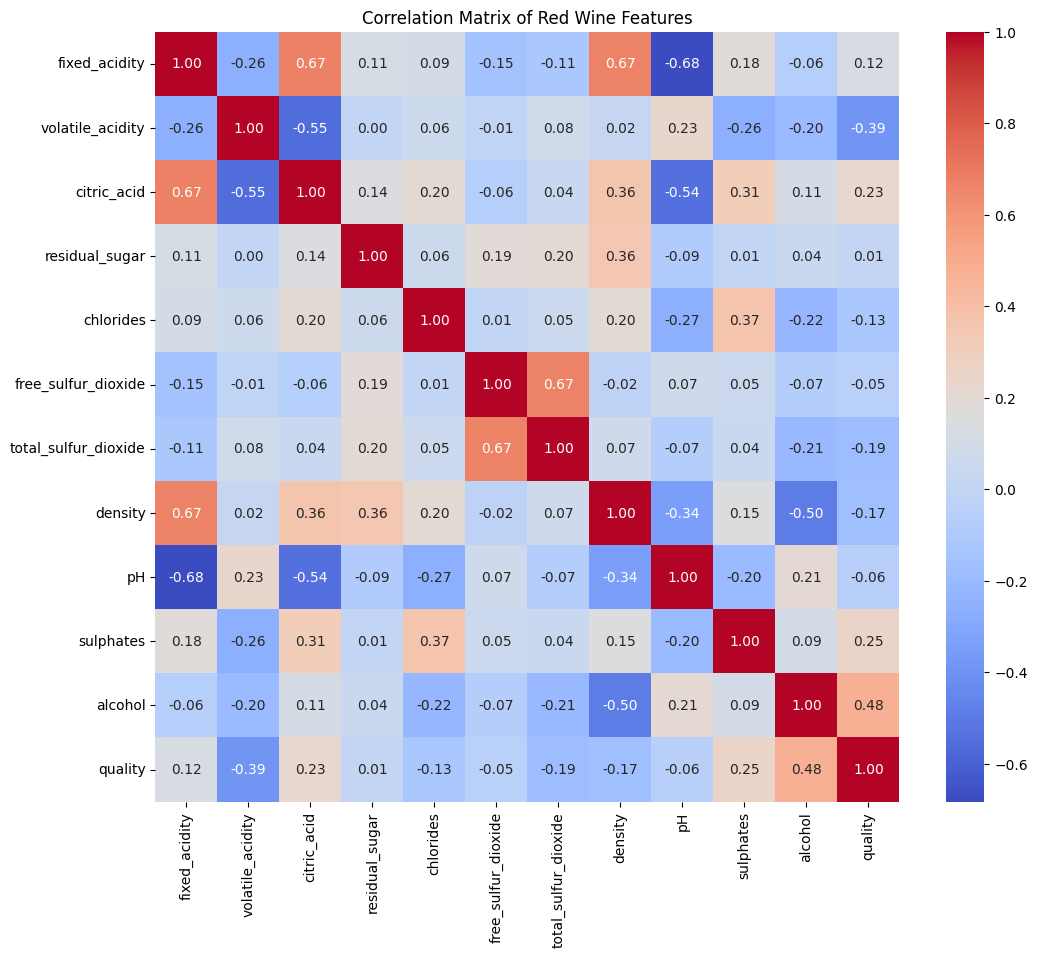

In [6]:
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Red Wine Features')
plt.show()

The heatmap showed a few notable correlations between variables, but nothing so strong that it would be redundant in our model. A few of these correlations were to be expected, such as fixed_acidity and citric_acid, or fixed_acidity and pH. However, some were less expected, like fixed_acidity and density. I decided to visualize this further using a scatterplot.

### Scatterplot of fixed acidity vs. density

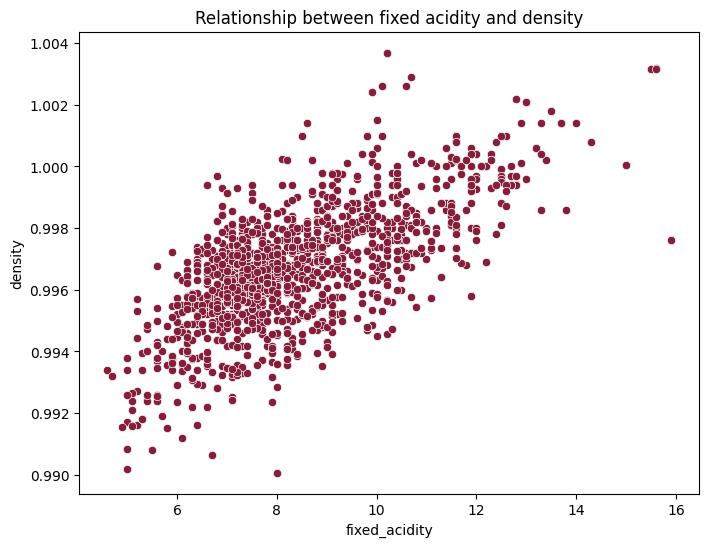

In [7]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='fixed_acidity', y='density', data=df, color='#851E38')
plt.title('Relationship between fixed acidity and density')
plt.xlabel('fixed_acidity')
plt.ylabel('density')
plt.show()

The above scatterplot shows us that while there is a correlation between fixed acidity and density it is not too strong to consider both features in our model.

Lastly, I wanted to look at the relationship between alcohol content and quality. I know that informally, alcohol content has been used to judge the quality of a wine, and I wanted to see if the dataset we are using supported that. I decided to group the values of the alcohol variable into bins and display them in a box plot, which can be seen below.

### Box plot of quality by alcohol content

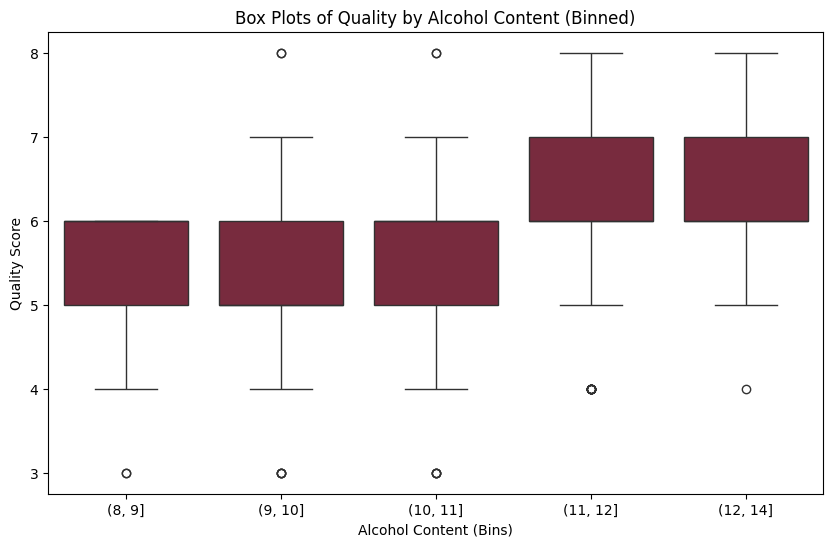

In [8]:
bin_edges = [8, 9, 10, 11, 12, 14]

df['alcohol_bin'] = pd.cut(df['alcohol'], bins=bin_edges)

plt.figure(figsize=(10, 6))
sns.boxplot(x='alcohol_bin', y='quality', data=df, color='#851E38')
plt.title('Box Plots of Quality by Alcohol Content (Binned)')
plt.xlabel('Alcohol Content (Bins)')
plt.ylabel('Quality Score')
plt.show()

We can see that there is a noticeable correlation between the two, but each bin also has a large range along with outliers. So while there is a general trend between them, it is fairly weak.

## Create and train regression model

Now that I feel confident we understand the dataset and it is ready to be worked with, we can start creating our machine learning model. As defined earlier in our code, our features variable *X* contains the chemical properties of each wine, and the target variable *y* contains the wine quality score.

With X and y already defined, we start by splitting the data into train and test sets using the sklearn function *train_test_split()*.

We will next normalize our feature data using *StandardScaler()*, which employs Z-score normalization. It's important to normalize the training data to ensure all features are on a similar scale, which prevents any single feature from dominating the learning process. We also normalize the target variable separately be dividing by 10, which will help the predictions make more sense on a 0-10 scale later on.

Finally, we initialize a linear regression model and train it on the scaled training data.

In [2]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialize scaler
scaler = StandardScaler()

# fit and transform training feature data
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)   # convert back to pandas df

y_train_scaled = y_train / 10

# train model
lin_model = LinearRegression()
lin_model.fit(X_train_scaled, y_train_scaled)

LinearRegression()

### Test the model with testing data

Now that our model is trained, we can use the test split of our data to test it's accuracy. We first normalize the test data with the same *scaler* we used on the training data. We then use the *predict()* function inputting our test feature data.

We can then compare the predicted values from the model to the actual values given in the data. We can check the model's accuracy using Mean Squared Error (MSE). The lower the MSE, the more accurate the model.

In [3]:
# transform test data
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)   # convert back to pandas df

y_test_scaled = y_test / 10

# test model on test data
y_pred_scaled = lin_model.predict(X_test_scaled)
y_pred = y_pred_scaled * 10

# mean squared error
mse_scaled = mean_squared_error(y_test_scaled, y_pred_scaled)
mse = mse_scaled * (10**2)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.3900251439643171


When evaluating the test data, we calcuate an MSE of 0.39. This doesn't tell us much by itself, but this value can be used to compare other machine learning models if we're trying to find the most accurate one.

Below, I've created a scatterplot showing the actual wine quality scores vs. those predicted by the model.

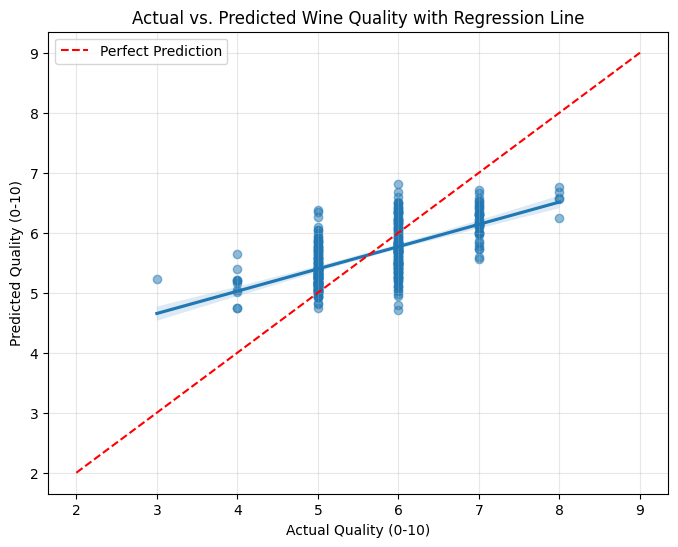

In [4]:
# Create the scatter plot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.5}) #alpha for transparency, to make it clear where datapoints overlap
plt.xlabel("Actual Quality (0-10)")
plt.ylabel("Predicted Quality (0-10)")
plt.title("Actual vs. Predicted Wine Quality with Regression Line")
plt.plot([2,9],[2,9], color = "red", linestyle = "--", label = "Perfect Prediction") #Add a perfect prediction line to see how close the model is
plt.legend()
plt.grid(alpha = 0.3) #Add a subtle grid for better readability
plt.show()

## Applying the predictive model to new data

Now that we have tested our model, we want to use it to predict the wine quality of user-input data. We want to create a straightforward way for a winery to input the properties of a new wine and receive a prediction of its quality. In the code blocks below, we will do exactly that.

First we will define a function *predict_wine_quality()* that takes a list of user-input values and feeds it to the linear regression model we've created. For a good user experience, we also include the units for each value they are asked to input.

In [5]:
def predict_wine_quality(user_input):
    user_input_df = pd.DataFrame([user_input], columns=X.columns)
    scaled_user_input = scaler.transform(user_input_df)  # reuse the 'scaler'
    scaled_user_input = pd.DataFrame(scaled_user_input, columns=X.columns)   # convert back to pandas df
    prediction = lin_model.predict(scaled_user_input)
    return prediction[0]

# Define a dictionary of units
units = {
    'fixed_acidity': 'g/L',
    'volatile_acidity': 'g/L',
    'citric_acid': 'g/L',
    'residual_sugar': 'g/L',
    'chlorides': 'g/L',
    'free_sulfur_dioxide': 'mg/L',
    'total_sulfur_dioxide': 'mg/L',
    'density': 'g/mL',
    'pH': '',    # unitless
    'sulphates': 'g/L',
    'alcohol': '% vol'
}

### Test Run

In order to test the program, we will now run an example of how it is intended to work. The below code block inserts the first row of our training data as the input to the *predict_wine_quality* function, and a number of other components ensure clear formatting. Finally, the predicted wine value is output.

Note: In my testing, I found that if a user input values far outside the norm for each of the wine properties, the model would sometimes predict values outside of the desired 0-10 range. This is not a problem when realistic values are entered, but for the most streamlined user experience, I decided to use numpy.clip in order to keep the values within our desired range.

Run the below code block to see an example of the program.

In [6]:
print("\n--- Test Run ---\n")
test_input = X.iloc[0].to_list()  # get the first row from your training data
test_prediction = round(predict_wine_quality(test_input), 2) * 10
clipped_test_prediction = np.clip(test_prediction, 0, 10)

# Calculate the maximum length of the prompts for alignment
max_prompt_length = max(len(f'{feature} ({units.get(feature, "")}): ' if units.get(feature) else f'{feature}: ') for feature in X.columns)

print("Using first row of training data as an example:\n")
for i, feature in enumerate(X.columns):
    unit = units.get(feature, '')
    prompt = f'{feature} ({unit}): ' if unit else f'{feature}: '
    print(f"{prompt:<{max_prompt_length+2}}{test_input[i]:}")  # Align the values

print(f"\nPredicted quality (0-10): {clipped_test_prediction}\n")



--- Test Run ---

Using first row of training data as an example:

fixed_acidity (g/L):           7.4
volatile_acidity (g/L):        0.7
citric_acid (g/L):             0.0
residual_sugar (g/L):          1.9
chlorides (g/L):               0.076
free_sulfur_dioxide (mg/L):    11.0
total_sulfur_dioxide (mg/L):   34.0
density (g/mL):                0.9978
pH:                            3.51
sulphates (g/L):               0.56
alcohol (% vol):               9.4

Predicted quality (0-10): 5.0


# User Application

In order to predict the quality of a wine, you will need to run the following code block and enter the measured values of each property of your wine. When the last measure is entered, the model will predict the quality of your wine on a scale from 0-10.

If another wine's quality is to be predicted, all you need to do is run the code block again to enter the new values.

In [ ]:
wine_properties = {}

for feature in X.columns:
    while True:
        try:
            unit = units.get(feature, '')  # Get the unit, default to empty string if not found
            prompt = f'{feature} ({unit}): ' if unit else f'{feature}: ' #Conditional prompt
            value = float(input(f"{prompt:<{max_prompt_length+2}}")) # Align the input prompt
            wine_properties[feature] = value
            break  # Exit the loop if input is valid
        except ValueError:
            print("Invalid input. Please enter a number.")

# rescale and clip results to 0-10
predicted_quality = round(predict_wine_quality(list(wine_properties.values())),2) * 10
clipped_prediction = np.clip(predicted_quality, 0, 10)

print('\nYour wine\'s predicted quality score (0-10) is: ' + str(clipped_prediction))